In [214]:
%matplotlib inline
import argparse
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [215]:
# set a manual seed to prevent different result while every running

manualSeed = 999
print("Random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [230]:
data_root = "./CAN_image_dataset(L)/"    # dataset root
workers = 1                 # using thread numbers
batch_size = 128            # batch_size
nc = 1                      # number of channel from input images
num_epochs = 100             # number of training epochs
lr = 0.0002                 # learning rate
beta1 = 0.5                 # hyperparameter for adam optimizer
ngpu = 1                    # number of available gpu

In [217]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=True,num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

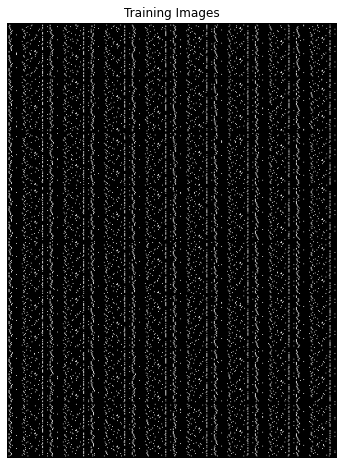

In [218]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))

In [219]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [220]:
# v1 : except nn.BatchNorm2d(channel size)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input : N x channel noise x 1 x 1
            nn.ConvTranspose2d(256,512,(4,3),stride=1,bias=False),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # fourth layer,
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
            nn.ReLU(True),
            # Final layer
            nn.ConvTranspose2d(64,3,4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        return self.main(input)

In [221]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Tanh()
  )
)


In [222]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu,
        self.main = nn.Sequential(
            nn.Conv2d(3,3,(4,3),stride=(2,1),padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(3,3,(4,3),stride=(2,1),padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(3,1,(16,48),stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [223]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 3, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(3, 1, kernel_size=(16, 48), stride=(1, 1), bias=False)
    (5): Sigmoid()
  )
)


In [224]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [231]:
# train process0
from tqdm import tqdm
import time

# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/121]	Loss_D: 1.2817	Loss_G: 0.6528	D(x): 0.5826	D(G(z)): 0.5235 / 0.5206
[0/100][50/121]	Loss_D: 1.2784	Loss_G: 0.6739	D(x): 0.5726	D(G(z)): 0.5135 / 0.5097
[0/100][100/121]	Loss_D: 1.2961	Loss_G: 0.6353	D(x): 0.5868	D(G(z)): 0.5336 / 0.5298


  1%|          | 1/100 [00:07<13:03,  7.92s/it]

[1/100][0/121]	Loss_D: 1.3148	Loss_G: 0.6297	D(x): 0.5811	D(G(z)): 0.5378 / 0.5327
[1/100][50/121]	Loss_D: 1.3047	Loss_G: 0.6013	D(x): 0.6073	D(G(z)): 0.5532 / 0.5481
[1/100][100/121]	Loss_D: 1.2547	Loss_G: 0.6303	D(x): 0.6188	D(G(z)): 0.5389 / 0.5324


  2%|▏         | 2/100 [00:15<12:47,  7.83s/it]

[2/100][0/121]	Loss_D: 1.1823	Loss_G: 0.6181	D(x): 0.6702	D(G(z)): 0.5424 / 0.5389
[2/100][50/121]	Loss_D: 1.3120	Loss_G: 0.5709	D(x): 0.6414	D(G(z)): 0.5798 / 0.5650
[2/100][100/121]	Loss_D: 1.1332	Loss_G: 0.6581	D(x): 0.6809	D(G(z)): 0.5268 / 0.5178


  3%|▎         | 3/100 [00:23<12:19,  7.63s/it]

[3/100][0/121]	Loss_D: 1.0878	Loss_G: 0.6378	D(x): 0.7219	D(G(z)): 0.5330 / 0.5284
[3/100][50/121]	Loss_D: 1.1755	Loss_G: 0.5755	D(x): 0.7113	D(G(z)): 0.5659 / 0.5624
[3/100][100/121]	Loss_D: 1.1246	Loss_G: 0.5421	D(x): 0.7871	D(G(z)): 0.5872 / 0.5815


  4%|▍         | 4/100 [00:30<12:03,  7.53s/it]

[4/100][0/121]	Loss_D: 1.1343	Loss_G: 0.6505	D(x): 0.6848	D(G(z)): 0.5299 / 0.5218
[4/100][50/121]	Loss_D: 0.9540	Loss_G: 0.6662	D(x): 0.8039	D(G(z)): 0.5206 / 0.5136
[4/100][100/121]	Loss_D: 1.1825	Loss_G: 0.6716	D(x): 0.6829	D(G(z)): 0.5506 / 0.5109


  5%|▌         | 5/100 [00:38<12:03,  7.61s/it]

[5/100][0/121]	Loss_D: 1.1114	Loss_G: 0.7788	D(x): 0.6243	D(G(z)): 0.4715 / 0.4591
[5/100][50/121]	Loss_D: 1.2831	Loss_G: 0.4878	D(x): 0.7651	D(G(z)): 0.6373 / 0.6140
[5/100][100/121]	Loss_D: 0.8213	Loss_G: 0.7791	D(x): 0.8188	D(G(z)): 0.4623 / 0.4588


  6%|▌         | 6/100 [00:45<11:55,  7.61s/it]

[6/100][0/121]	Loss_D: 0.8723	Loss_G: 0.6347	D(x): 0.8956	D(G(z)): 0.5332 / 0.5301
[6/100][50/121]	Loss_D: 0.7366	Loss_G: 0.7007	D(x): 0.9540	D(G(z)): 0.4981 / 0.4962
[6/100][100/121]	Loss_D: 0.6671	Loss_G: 0.7468	D(x): 0.9766	D(G(z)): 0.4745 / 0.4739


  7%|▋         | 7/100 [00:53<12:03,  7.78s/it]

[7/100][0/121]	Loss_D: 0.6848	Loss_G: 0.7191	D(x): 0.9834	D(G(z)): 0.4873 / 0.4872
[7/100][50/121]	Loss_D: 0.6978	Loss_G: 0.6970	D(x): 0.9915	D(G(z)): 0.4981 / 0.4981
[7/100][100/121]	Loss_D: 0.6972	Loss_G: 0.6946	D(x): 0.9945	D(G(z)): 0.4993 / 0.4993


  8%|▊         | 8/100 [01:01<11:43,  7.65s/it]

[8/100][0/121]	Loss_D: 0.6978	Loss_G: 0.6932	D(x): 0.9953	D(G(z)): 0.5000 / 0.5000
[8/100][50/121]	Loss_D: 0.6984	Loss_G: 0.6915	D(x): 0.9964	D(G(z)): 0.5008 / 0.5008
[8/100][100/121]	Loss_D: 1.2762	Loss_G: 0.5132	D(x): 0.7651	D(G(z)): 0.6347 / 0.5986


  9%|▉         | 9/100 [01:08<11:28,  7.57s/it]

[9/100][0/121]	Loss_D: 0.9247	Loss_G: 0.6550	D(x): 0.8411	D(G(z)): 0.5281 / 0.5194
[9/100][50/121]	Loss_D: 0.8421	Loss_G: 0.6475	D(x): 0.9180	D(G(z)): 0.5307 / 0.5233
[9/100][100/121]	Loss_D: 0.7311	Loss_G: 0.6987	D(x): 0.9582	D(G(z)): 0.4976 / 0.4972


 10%|█         | 10/100 [01:16<11:15,  7.51s/it]

[10/100][0/121]	Loss_D: 0.7153	Loss_G: 0.6990	D(x): 0.9726	D(G(z)): 0.4972 / 0.4971
[10/100][50/121]	Loss_D: 0.7071	Loss_G: 0.6926	D(x): 0.9867	D(G(z)): 0.5003 / 0.5003
[10/100][100/121]	Loss_D: 0.7024	Loss_G: 0.6922	D(x): 0.9917	D(G(z)): 0.5005 / 0.5005


 11%|█         | 11/100 [01:23<11:03,  7.46s/it]

[11/100][0/121]	Loss_D: 0.7017	Loss_G: 0.6921	D(x): 0.9926	D(G(z)): 0.5005 / 0.5005
[11/100][50/121]	Loss_D: 0.7001	Loss_G: 0.6918	D(x): 0.9945	D(G(z)): 0.5007 / 0.5007
[11/100][100/121]	Loss_D: 0.7016	Loss_G: 0.6894	D(x): 0.9954	D(G(z)): 0.5019 / 0.5019


 12%|█▏        | 12/100 [01:30<10:56,  7.46s/it]

[12/100][0/121]	Loss_D: 0.8679	Loss_G: 0.5553	D(x): 0.9952	D(G(z)): 0.5781 / 0.5739
[12/100][50/121]	Loss_D: 0.7531	Loss_G: 0.6803	D(x): 0.9589	D(G(z)): 0.5089 / 0.5065
[12/100][100/121]	Loss_D: 0.7328	Loss_G: 0.6790	D(x): 0.9762	D(G(z)): 0.5077 / 0.5071


 13%|█▎        | 13/100 [01:38<10:57,  7.56s/it]

[13/100][0/121]	Loss_D: 0.7290	Loss_G: 0.6805	D(x): 0.9790	D(G(z)): 0.5073 / 0.5064
[13/100][50/121]	Loss_D: 0.7210	Loss_G: 0.6930	D(x): 0.9727	D(G(z)): 0.5001 / 0.5001
[13/100][100/121]	Loss_D: 0.7056	Loss_G: 0.6929	D(x): 0.9879	D(G(z)): 0.5001 / 0.5001


 14%|█▍        | 14/100 [01:46<10:59,  7.67s/it]

[14/100][0/121]	Loss_D: 0.7031	Loss_G: 0.6928	D(x): 0.9904	D(G(z)): 0.5002 / 0.5002
[14/100][50/121]	Loss_D: 0.7003	Loss_G: 0.6927	D(x): 0.9934	D(G(z)): 0.5002 / 0.5002
[14/100][100/121]	Loss_D: 0.6985	Loss_G: 0.6926	D(x): 0.9953	D(G(z)): 0.5003 / 0.5003


 15%|█▌        | 15/100 [01:54<10:47,  7.62s/it]

[15/100][0/121]	Loss_D: 0.6981	Loss_G: 0.6925	D(x): 0.9957	D(G(z)): 0.5003 / 0.5003
[15/100][50/121]	Loss_D: 0.6975	Loss_G: 0.6924	D(x): 0.9964	D(G(z)): 0.5004 / 0.5004
[15/100][100/121]	Loss_D: 0.6968	Loss_G: 0.6924	D(x): 0.9971	D(G(z)): 0.5004 / 0.5004


 16%|█▌        | 16/100 [02:01<10:36,  7.57s/it]

[16/100][0/121]	Loss_D: 0.6966	Loss_G: 0.6924	D(x): 0.9972	D(G(z)): 0.5004 / 0.5004
[16/100][50/121]	Loss_D: 0.6960	Loss_G: 0.6926	D(x): 0.9977	D(G(z)): 0.5003 / 0.5003
[16/100][100/121]	Loss_D: 0.6954	Loss_G: 0.6929	D(x): 0.9980	D(G(z)): 0.5001 / 0.5001


 17%|█▋        | 17/100 [02:09<10:26,  7.55s/it]

[17/100][0/121]	Loss_D: 0.6953	Loss_G: 0.6930	D(x): 0.9980	D(G(z)): 0.5001 / 0.5001
[17/100][50/121]	Loss_D: 0.7048	Loss_G: 0.6942	D(x): 0.9874	D(G(z)): 0.4995 / 0.4995
[17/100][100/121]	Loss_D: 0.7005	Loss_G: 0.6928	D(x): 0.9932	D(G(z)): 0.5002 / 0.5002


 18%|█▊        | 18/100 [02:16<10:14,  7.50s/it]

[18/100][0/121]	Loss_D: 0.6988	Loss_G: 0.6938	D(x): 0.9938	D(G(z)): 0.4997 / 0.4997
[18/100][50/121]	Loss_D: 0.6985	Loss_G: 0.6924	D(x): 0.9954	D(G(z)): 0.5004 / 0.5004
[18/100][100/121]	Loss_D: 0.6985	Loss_G: 0.6917	D(x): 0.9962	D(G(z)): 0.5007 / 0.5007


 19%|█▉        | 19/100 [02:24<10:09,  7.52s/it]

[19/100][0/121]	Loss_D: 0.6985	Loss_G: 0.6914	D(x): 0.9965	D(G(z)): 0.5009 / 0.5009
[19/100][50/121]	Loss_D: 0.6974	Loss_G: 0.6918	D(x): 0.9971	D(G(z)): 0.5007 / 0.5007
[19/100][100/121]	Loss_D: 0.6963	Loss_G: 0.6925	D(x): 0.9975	D(G(z)): 0.5003 / 0.5003


 20%|██        | 20/100 [02:31<10:08,  7.61s/it]

[20/100][0/121]	Loss_D: 0.6959	Loss_G: 0.6930	D(x): 0.9974	D(G(z)): 0.5001 / 0.5001
[20/100][50/121]	Loss_D: 0.6949	Loss_G: 0.6937	D(x): 0.9978	D(G(z)): 0.4998 / 0.4997
[20/100][100/121]	Loss_D: 0.6947	Loss_G: 0.6936	D(x): 0.9980	D(G(z)): 0.4998 / 0.4998


 21%|██        | 21/100 [02:39<10:03,  7.63s/it]

[21/100][0/121]	Loss_D: 0.6947	Loss_G: 0.6935	D(x): 0.9981	D(G(z)): 0.4998 / 0.4998
[21/100][50/121]	Loss_D: 0.6948	Loss_G: 0.6932	D(x): 0.9983	D(G(z)): 0.5000 / 0.5000
[21/100][100/121]	Loss_D: 0.6948	Loss_G: 0.6930	D(x): 0.9986	D(G(z)): 0.5001 / 0.5001


 22%|██▏       | 22/100 [02:47<09:59,  7.69s/it]

[22/100][0/121]	Loss_D: 0.6948	Loss_G: 0.6929	D(x): 0.9986	D(G(z)): 0.5001 / 0.5001
[22/100][50/121]	Loss_D: 0.6946	Loss_G: 0.6930	D(x): 0.9988	D(G(z)): 0.5001 / 0.5001
[22/100][100/121]	Loss_D: 0.6944	Loss_G: 0.6930	D(x): 0.9989	D(G(z)): 0.5001 / 0.5001


 23%|██▎       | 23/100 [02:55<09:56,  7.75s/it]

[23/100][0/121]	Loss_D: 0.6943	Loss_G: 0.6931	D(x): 0.9989	D(G(z)): 0.5000 / 0.5000
[23/100][50/121]	Loss_D: 0.6942	Loss_G: 0.6931	D(x): 0.9990	D(G(z)): 0.5000 / 0.5000
[23/100][100/121]	Loss_D: 0.6941	Loss_G: 0.6931	D(x): 0.9991	D(G(z)): 0.5000 / 0.5000


 24%|██▍       | 24/100 [03:02<09:43,  7.68s/it]

[24/100][0/121]	Loss_D: 0.6941	Loss_G: 0.6931	D(x): 0.9991	D(G(z)): 0.5000 / 0.5000
[24/100][50/121]	Loss_D: 0.6940	Loss_G: 0.6931	D(x): 0.9992	D(G(z)): 0.5000 / 0.5000
[24/100][100/121]	Loss_D: 0.6939	Loss_G: 0.6931	D(x): 0.9993	D(G(z)): 0.5000 / 0.5000


 25%|██▌       | 25/100 [03:10<09:32,  7.64s/it]

[25/100][0/121]	Loss_D: 0.6939	Loss_G: 0.6931	D(x): 0.9993	D(G(z)): 0.5000 / 0.5000
[25/100][50/121]	Loss_D: 0.6938	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000
[25/100][100/121]	Loss_D: 0.6938	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000


 26%|██▌       | 26/100 [03:18<09:30,  7.71s/it]

[26/100][0/121]	Loss_D: 0.6938	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000
[26/100][50/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000
[26/100][100/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000


 27%|██▋       | 27/100 [03:25<09:23,  7.72s/it]

[27/100][0/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000
[27/100][50/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000
[27/100][100/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000


 28%|██▊       | 28/100 [03:33<09:12,  7.68s/it]

[28/100][0/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[28/100][50/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[28/100][100/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000


 29%|██▉       | 29/100 [03:41<09:08,  7.73s/it]

[29/100][0/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[29/100][50/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[29/100][100/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000


 30%|███       | 30/100 [03:48<08:55,  7.65s/it]

[30/100][0/121]	Loss_D: 0.6936	Loss_G: 0.6930	D(x): 0.9997	D(G(z)): 0.5001 / 0.5001
[30/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6932	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[30/100][100/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000


 31%|███       | 31/100 [03:56<08:42,  7.57s/it]

[31/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[31/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[31/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000


 32%|███▏      | 32/100 [04:04<08:55,  7.88s/it]

[32/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[32/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[32/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 33%|███▎      | 33/100 [04:12<08:47,  7.88s/it]

[33/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[33/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[33/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 34%|███▍      | 34/100 [04:20<08:32,  7.77s/it]

[34/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[34/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[34/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 35%|███▌      | 35/100 [04:27<08:23,  7.74s/it]

[35/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6932	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[35/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[35/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 36%|███▌      | 36/100 [04:36<08:31,  7.99s/it]

[36/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[36/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[36/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 37%|███▋      | 37/100 [04:44<08:17,  7.90s/it]

[37/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[37/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[37/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 38%|███▊      | 38/100 [04:51<08:06,  7.84s/it]

[38/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[38/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[38/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 39%|███▉      | 39/100 [04:59<07:54,  7.78s/it]

[39/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[39/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[39/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 40%|████      | 40/100 [05:07<07:45,  7.76s/it]

[40/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[40/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[40/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 41%|████      | 41/100 [05:14<07:39,  7.78s/it]

[41/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[41/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[41/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 42%|████▏     | 42/100 [05:22<07:27,  7.71s/it]

[42/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[42/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[42/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 43%|████▎     | 43/100 [05:30<07:15,  7.64s/it]

[43/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[43/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[43/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 44%|████▍     | 44/100 [05:37<07:03,  7.56s/it]

[44/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[44/100][50/121]	Loss_D: 0.6917	Loss_G: 0.6947	D(x): 0.9999	D(G(z)): 0.4992 / 0.4992
[44/100][100/121]	Loss_D: 0.6910	Loss_G: 0.6955	D(x): 0.9999	D(G(z)): 0.4989 / 0.4988


 45%|████▌     | 45/100 [05:44<06:52,  7.51s/it]

[45/100][0/121]	Loss_D: 0.6925	Loss_G: 0.6939	D(x): 0.9999	D(G(z)): 0.4996 / 0.4996
[45/100][50/121]	Loss_D: 0.6928	Loss_G: 0.6936	D(x): 0.9999	D(G(z)): 0.4998 / 0.4998
[45/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6932	D(x): 0.9999	D(G(z)): 0.5001 / 0.5000


 46%|████▌     | 46/100 [05:52<06:44,  7.49s/it]

[46/100][0/121]	Loss_D: 0.7895	Loss_G: 0.6281	D(x): 0.9996	D(G(z)): 0.5456 / 0.5337
[46/100][50/121]	Loss_D: 1.2087	Loss_G: 0.4371	D(x): 0.8738	D(G(z)): 0.6581 / 0.6459
[46/100][100/121]	Loss_D: 2.0383	Loss_G: 0.2588	D(x): 0.7460	D(G(z)): 0.8251 / 0.7720


 47%|████▋     | 47/100 [05:59<06:35,  7.46s/it]

[47/100][0/121]	Loss_D: 1.2229	Loss_G: 0.4866	D(x): 0.8173	D(G(z)): 0.6396 / 0.6147
[47/100][50/121]	Loss_D: 0.9490	Loss_G: 0.6696	D(x): 0.8108	D(G(z)): 0.5222 / 0.5119
[47/100][100/121]	Loss_D: 0.7270	Loss_G: 0.7960	D(x): 0.8899	D(G(z)): 0.4567 / 0.4511


 48%|████▊     | 48/100 [06:06<06:26,  7.44s/it]

[48/100][0/121]	Loss_D: 1.4470	Loss_G: 0.3821	D(x): 0.8492	D(G(z)): 0.7228 / 0.6824
[48/100][50/121]	Loss_D: 1.0310	Loss_G: 0.4990	D(x): 0.9163	D(G(z)): 0.6106 / 0.6071
[48/100][100/121]	Loss_D: 0.7537	Loss_G: 0.8416	D(x): 0.8389	D(G(z)): 0.4386 / 0.4310


 49%|████▉     | 49/100 [06:14<06:20,  7.46s/it]

[49/100][0/121]	Loss_D: 0.8514	Loss_G: 0.6548	D(x): 0.8958	D(G(z)): 0.5234 / 0.5195
[49/100][50/121]	Loss_D: 1.1565	Loss_G: 0.6114	D(x): 0.7195	D(G(z)): 0.5618 / 0.5426
[49/100][100/121]	Loss_D: 1.5681	Loss_G: 0.4160	D(x): 0.6676	D(G(z)): 0.6868 / 0.6597


 50%|█████     | 50/100 [06:21<06:12,  7.45s/it]

[50/100][0/121]	Loss_D: 1.2767	Loss_G: 0.5594	D(x): 0.6746	D(G(z)): 0.5857 / 0.5716
[50/100][50/121]	Loss_D: 0.8881	Loss_G: 0.6768	D(x): 0.8420	D(G(z)): 0.5111 / 0.5083
[50/100][100/121]	Loss_D: 0.8419	Loss_G: 0.6400	D(x): 0.9173	D(G(z)): 0.5302 / 0.5273


 51%|█████     | 51/100 [06:29<06:04,  7.43s/it]

[51/100][0/121]	Loss_D: 0.7689	Loss_G: 0.6962	D(x): 0.9277	D(G(z)): 0.5003 / 0.4985
[51/100][50/121]	Loss_D: 0.7286	Loss_G: 0.7108	D(x): 0.9506	D(G(z)): 0.4923 / 0.4912
[51/100][100/121]	Loss_D: 0.7454	Loss_G: 0.6790	D(x): 0.9643	D(G(z)): 0.5078 / 0.5071


 52%|█████▏    | 52/100 [06:36<05:56,  7.42s/it]

[52/100][0/121]	Loss_D: 0.7307	Loss_G: 0.6885	D(x): 0.9686	D(G(z)): 0.5028 / 0.5023
[52/100][50/121]	Loss_D: 0.7061	Loss_G: 0.7014	D(x): 0.9797	D(G(z)): 0.4962 / 0.4959
[52/100][100/121]	Loss_D: 0.7067	Loss_G: 0.6959	D(x): 0.9840	D(G(z)): 0.4987 / 0.4986


 53%|█████▎    | 53/100 [06:44<05:48,  7.41s/it]

[53/100][0/121]	Loss_D: 0.7052	Loss_G: 0.6952	D(x): 0.9862	D(G(z)): 0.4991 / 0.4990
[53/100][50/121]	Loss_D: 0.8245	Loss_G: 0.5972	D(x): 0.9843	D(G(z)): 0.5546 / 0.5504
[53/100][100/121]	Loss_D: 0.7113	Loss_G: 0.6993	D(x): 0.9761	D(G(z)): 0.4970 / 0.4969


 54%|█████▍    | 54/100 [06:51<05:41,  7.43s/it]

[54/100][0/121]	Loss_D: 0.7059	Loss_G: 0.6986	D(x): 0.9821	D(G(z)): 0.4973 / 0.4973
[54/100][50/121]	Loss_D: 0.7030	Loss_G: 0.6967	D(x): 0.9869	D(G(z)): 0.4983 / 0.4982
[54/100][100/121]	Loss_D: 0.7003	Loss_G: 0.6950	D(x): 0.9910	D(G(z)): 0.4991 / 0.4991


 55%|█████▌    | 55/100 [06:58<05:33,  7.42s/it]

[55/100][0/121]	Loss_D: 0.6992	Loss_G: 0.6947	D(x): 0.9924	D(G(z)): 0.4992 / 0.4992
[55/100][50/121]	Loss_D: 0.6980	Loss_G: 0.6943	D(x): 0.9940	D(G(z)): 0.4994 / 0.4994
[55/100][100/121]	Loss_D: 0.6973	Loss_G: 0.6939	D(x): 0.9952	D(G(z)): 0.4996 / 0.4996


 56%|█████▌    | 56/100 [07:06<05:26,  7.42s/it]

[56/100][0/121]	Loss_D: 0.6969	Loss_G: 0.6937	D(x): 0.9957	D(G(z)): 0.4997 / 0.4997
[56/100][50/121]	Loss_D: 0.6961	Loss_G: 0.6936	D(x): 0.9966	D(G(z)): 0.4998 / 0.4998
[56/100][100/121]	Loss_D: 0.6956	Loss_G: 0.6936	D(x): 0.9971	D(G(z)): 0.4998 / 0.4998


 57%|█████▋    | 57/100 [07:13<05:18,  7.41s/it]

[57/100][0/121]	Loss_D: 0.6959	Loss_G: 0.6936	D(x): 0.9969	D(G(z)): 0.4998 / 0.4998
[57/100][50/121]	Loss_D: 0.6953	Loss_G: 0.6935	D(x): 0.9975	D(G(z)): 0.4998 / 0.4998
[57/100][100/121]	Loss_D: 0.6949	Loss_G: 0.6936	D(x): 0.9979	D(G(z)): 0.4998 / 0.4998


 58%|█████▊    | 58/100 [07:21<05:12,  7.43s/it]

[58/100][0/121]	Loss_D: 0.6949	Loss_G: 0.6935	D(x): 0.9979	D(G(z)): 0.4998 / 0.4998
[58/100][50/121]	Loss_D: 0.6954	Loss_G: 0.6928	D(x): 0.9981	D(G(z)): 0.5002 / 0.5002
[58/100][100/121]	Loss_D: 0.6973	Loss_G: 0.6908	D(x): 0.9983	D(G(z)): 0.5012 / 0.5012


 59%|█████▉    | 59/100 [07:28<05:04,  7.42s/it]

[59/100][0/121]	Loss_D: 0.6979	Loss_G: 0.6901	D(x): 0.9983	D(G(z)): 0.5016 / 0.5015
[59/100][50/121]	Loss_D: 0.6940	Loss_G: 0.6942	D(x): 0.9983	D(G(z)): 0.4996 / 0.4995
[59/100][100/121]	Loss_D: 0.6918	Loss_G: 0.6964	D(x): 0.9981	D(G(z)): 0.4984 / 0.4984


 60%|██████    | 60/100 [07:36<04:56,  7.42s/it]

[60/100][0/121]	Loss_D: 0.6921	Loss_G: 0.6959	D(x): 0.9982	D(G(z)): 0.4986 / 0.4986
[60/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6947	D(x): 0.9983	D(G(z)): 0.4992 / 0.4992
[60/100][100/121]	Loss_D: 0.6937	Loss_G: 0.6940	D(x): 0.9986	D(G(z)): 0.4996 / 0.4996


 61%|██████    | 61/100 [07:43<04:51,  7.46s/it]

[61/100][0/121]	Loss_D: 0.6938	Loss_G: 0.6939	D(x): 0.9986	D(G(z)): 0.4996 / 0.4996
[61/100][50/121]	Loss_D: 0.6940	Loss_G: 0.6935	D(x): 0.9988	D(G(z)): 0.4998 / 0.4998
[61/100][100/121]	Loss_D: 0.6940	Loss_G: 0.6934	D(x): 0.9989	D(G(z)): 0.4999 / 0.4999


 62%|██████▏   | 62/100 [07:51<04:43,  7.47s/it]

[62/100][0/121]	Loss_D: 0.6940	Loss_G: 0.6933	D(x): 0.9990	D(G(z)): 0.4999 / 0.4999
[62/100][50/121]	Loss_D: 0.6941	Loss_G: 0.6931	D(x): 0.9991	D(G(z)): 0.5000 / 0.5000
[62/100][100/121]	Loss_D: 0.6940	Loss_G: 0.6931	D(x): 0.9991	D(G(z)): 0.5000 / 0.5000


 63%|██████▎   | 63/100 [07:58<04:36,  7.47s/it]

[63/100][0/121]	Loss_D: 0.6940	Loss_G: 0.6931	D(x): 0.9992	D(G(z)): 0.5000 / 0.5000
[63/100][50/121]	Loss_D: 0.6939	Loss_G: 0.6931	D(x): 0.9992	D(G(z)): 0.5000 / 0.5000
[63/100][100/121]	Loss_D: 0.6939	Loss_G: 0.6931	D(x): 0.9993	D(G(z)): 0.5000 / 0.5000


 64%|██████▍   | 64/100 [08:06<04:30,  7.51s/it]

[64/100][0/121]	Loss_D: 0.6938	Loss_G: 0.6931	D(x): 0.9993	D(G(z)): 0.5000 / 0.5000
[64/100][50/121]	Loss_D: 0.6938	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000
[64/100][100/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9994	D(G(z)): 0.5000 / 0.5000


 65%|██████▌   | 65/100 [08:14<04:33,  7.81s/it]

[65/100][0/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000
[65/100][50/121]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000
[65/100][100/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000


 66%|██████▌   | 66/100 [08:22<04:22,  7.73s/it]

[66/100][0/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9995	D(G(z)): 0.5000 / 0.5000
[66/100][50/121]	Loss_D: 0.6936	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[66/100][100/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000


 67%|██████▋   | 67/100 [08:30<04:16,  7.78s/it]

[67/100][0/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[67/100][50/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[67/100][100/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000


 68%|██████▊   | 68/100 [08:37<04:05,  7.66s/it]

[68/100][0/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9996	D(G(z)): 0.5000 / 0.5000
[68/100][50/121]	Loss_D: 0.6935	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[68/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000


 69%|██████▉   | 69/100 [08:45<03:56,  7.63s/it]

[69/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[69/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[69/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 70%|███████   | 70/100 [08:52<03:46,  7.55s/it]

[70/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9997	D(G(z)): 0.5000 / 0.5000
[70/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[70/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 71%|███████   | 71/100 [08:59<03:37,  7.51s/it]

[71/100][0/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[71/100][50/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[71/100][100/121]	Loss_D: 0.6934	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 72%|███████▏  | 72/100 [09:07<03:29,  7.48s/it]

[72/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[72/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[72/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 73%|███████▎  | 73/100 [09:15<03:25,  7.60s/it]

[73/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[73/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[73/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000


 74%|███████▍  | 74/100 [09:22<03:15,  7.53s/it]

[74/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[74/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9998	D(G(z)): 0.5000 / 0.5000
[74/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 75%|███████▌  | 75/100 [09:29<03:07,  7.50s/it]

[75/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[75/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[75/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 76%|███████▌  | 76/100 [09:37<02:59,  7.48s/it]

[76/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[76/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[76/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 77%|███████▋  | 77/100 [09:44<02:51,  7.44s/it]

[77/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[77/100][50/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[77/100][100/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 78%|███████▊  | 78/100 [09:52<02:43,  7.42s/it]

[78/100][0/121]	Loss_D: 0.6933	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[78/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[78/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 79%|███████▉  | 79/100 [09:59<02:35,  7.42s/it]

[79/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[79/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[79/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 80%|████████  | 80/100 [10:06<02:28,  7.41s/it]

[80/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[80/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[80/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 81%|████████  | 81/100 [10:14<02:20,  7.41s/it]

[81/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[81/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[81/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 82%|████████▏ | 82/100 [10:21<02:13,  7.41s/it]

[82/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[82/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[82/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 83%|████████▎ | 83/100 [10:29<02:06,  7.45s/it]

[83/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[83/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[83/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 84%|████████▍ | 84/100 [10:36<01:58,  7.43s/it]

[84/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[84/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[84/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 85%|████████▌ | 85/100 [10:44<01:51,  7.41s/it]

[85/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[85/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000
[85/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.5000 / 0.5000


 86%|████████▌ | 86/100 [10:51<01:43,  7.41s/it]

[86/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[86/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[86/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 87%|████████▋ | 87/100 [10:58<01:36,  7.41s/it]

[87/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[87/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[87/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 88%|████████▊ | 88/100 [11:07<01:32,  7.71s/it]

[88/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[88/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[88/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 89%|████████▉ | 89/100 [11:15<01:26,  7.82s/it]

[89/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[89/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[89/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 90%|█████████ | 90/100 [11:23<01:18,  7.82s/it]

[90/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[90/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[90/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 91%|█████████ | 91/100 [11:30<01:09,  7.78s/it]

[91/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[91/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[91/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 92%|█████████▏| 92/100 [11:38<01:01,  7.70s/it]

[92/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[92/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[92/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 93%|█████████▎| 93/100 [11:45<00:53,  7.65s/it]

[93/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[93/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[93/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 94%|█████████▍| 94/100 [11:53<00:45,  7.64s/it]

[94/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[94/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[94/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 95%|█████████▌| 95/100 [12:01<00:38,  7.63s/it]

[95/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[95/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[95/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 96%|█████████▌| 96/100 [12:08<00:30,  7.58s/it]

[96/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[96/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[96/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 97%|█████████▋| 97/100 [12:15<00:22,  7.50s/it]

[97/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[97/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[97/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 98%|█████████▊| 98/100 [12:23<00:14,  7.46s/it]

[98/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[98/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[98/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


 99%|█████████▉| 99/100 [12:31<00:07,  7.62s/it]

[99/100][0/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[99/100][50/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000
[99/100][100/121]	Loss_D: 0.6932	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.5000 / 0.5000


100%|██████████| 100/100 [12:38<00:00,  7.59s/it]


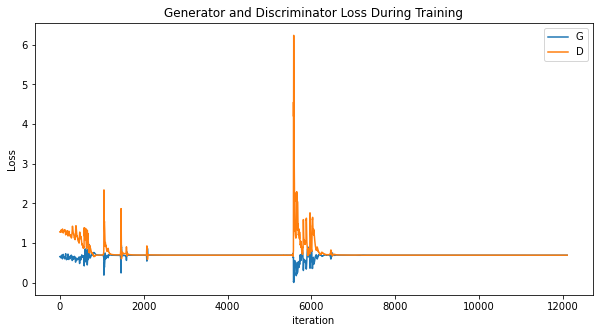

In [232]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

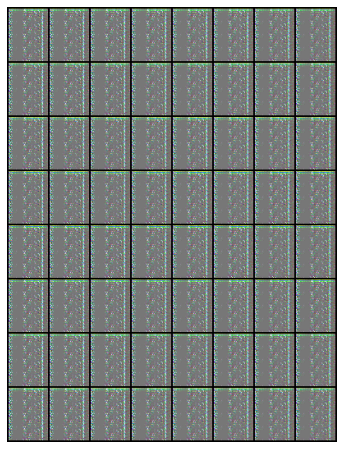

In [228]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

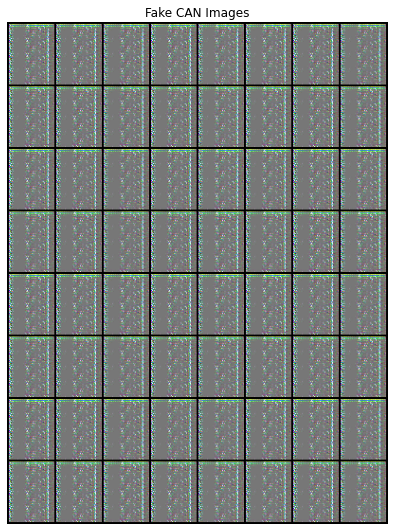

In [229]:
# bring real datas form dataloader
real_batch = next(iter(dataloader))

# print real images on display
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Fake CAN Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()